# Analytical Thermal Models
This notebook gathers the analytical investigations of the TATTOOS target temperature.

## Table of Contents

The heat balance in the target is:
$$
  P_{in}= m c_p\frac{dT}{dt}-P_{rad}-P_{cond}-P_{sub}-P_{therm}-P_{gas}
$$

With:
- $P_{in}$ the power deposited by the proton beam or the Joule heating: $\rho\frac{L}{S}I^2$
- $P_{rad}$ the losses via thermal radiation: $\frac{\sigma A_{1}(T_{1}^4-T_{2}^4)}{\frac{1}{\epsilon_{1}}+\left(\frac{r_{1}}{r_{2}}\right)\left(\frac{1-\epsilon_{2}}{\epsilon_{2}}\right)}$
- $P_{cond}$ the losses via conduction through the electrical connectors: $2\lambda A_{cond}\frac{dT}{dx}$
- $P_{sub}$ the losses via sublimation.
- $P_{therm}$ the losses via thermionic emissions.
- $P_{gas}$ the convective losses through the gas flow.


$$
  \rho\frac{L}{S}I^2= m c_p\frac{dT}{dt}-\frac{\sigma A_{1}(T_{1}^4-T_{2}^4)}{\frac{1}{\epsilon_{1}}+\left(\frac{r_{1}}{r_{2}}\right)\left(\frac{1-\epsilon_{2}}{\epsilon_{2}}\right)}-2\lambda A_{cond}\frac{dT}{dx}
$$

Assumptions are:
* T_amb for radiation and conduction is the same (393.15K)
* Only the container is radiating 
* Thermal conductivity is taken constant as 60 W/(m.K) since conduction contributes poorly to the cooling

### References
[1] R. N. Sagaidak, “Effects of beam wobbling and target rotation on the target temperature in experiments with intense heavy ion beams,” Phys. Rev. Accel. Beams, vol. 24, no. 8, p. 083001, Aug. 2021, doi: 10.1103/PhysRevAccelBeams.24.083001.


# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors 
%matplotlib inline

import time
import os
from scipy.optimize import fsolve
from scipy.optimize import fsolve, newton, brent, excitingmixing
from scipy.interpolate import interp1d
from scipy.integrate import simps
import scipy.constants as co



# Material Properties

In [2]:
#From Milosevic - Thermal Properties of Tantalum Between 300 and 2300 K
#Emissivity
def Eps(T):
    return -0.06835+1.8524*1e-4*T

#Specific heat [J/kg/K]  
def Cp(T):
    return 134.64+2.7981*1e-2*T-1.5971*1e-5*T**2+5.8259*1e-9*np.power(T,3)

#Resistivity [Ohm.m]
def Res(T):
    return -1.03*1e-8+5.1923*1e-10*T-6.3911*1e-14*T**2+5.1236*1e-18*np.power(T,3)

rho=16654 # Volumic mass Tantalum [kg/m3]

#From I.V. Savchenko - Thermal conductivity and thermal diffusivityof tantalum in the temperature rangefrom 293 to 1800 K
k=60                                         #Thermal conductivity Tantalum [W/(mK)]

plt.show()

# Transient

Mass of the target [kg]: 1.69
Mass of the container [kg]: 0.18


C:\Users\martin_r\AppData\Local\Temp\ipykernel_23704\2604482603.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T=float(T)


Final cooling temperature in [K] after 600s: 400.1
Final cooling temperature in [°C] after 600s: 126.95
Maximum temperature in [K]: 2411.17
Maximum temperature in [°C]: 2138.02
Maximum power in [kW]: 23.5


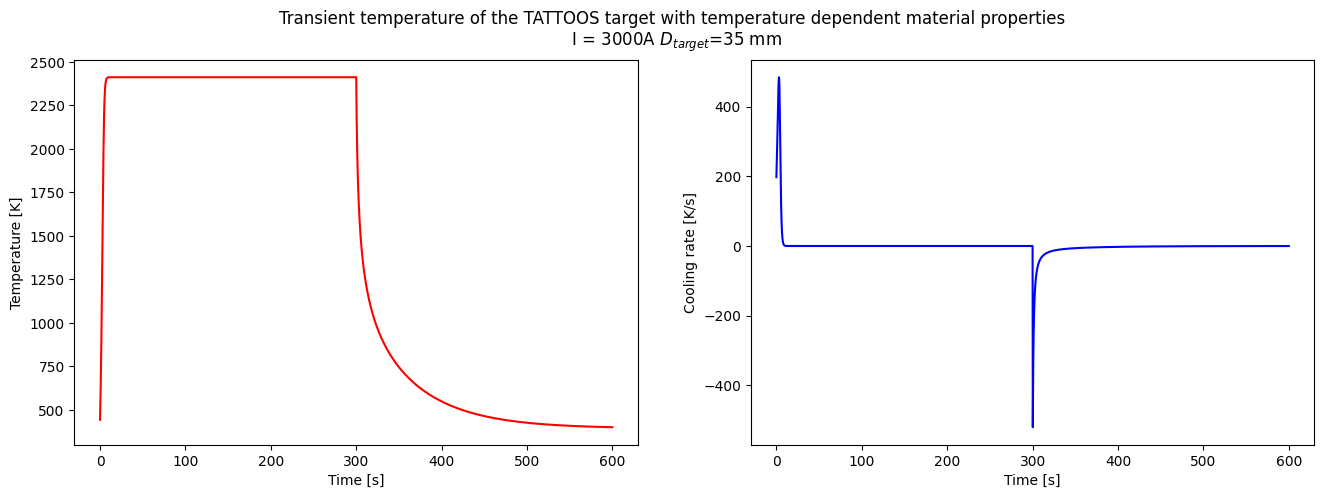

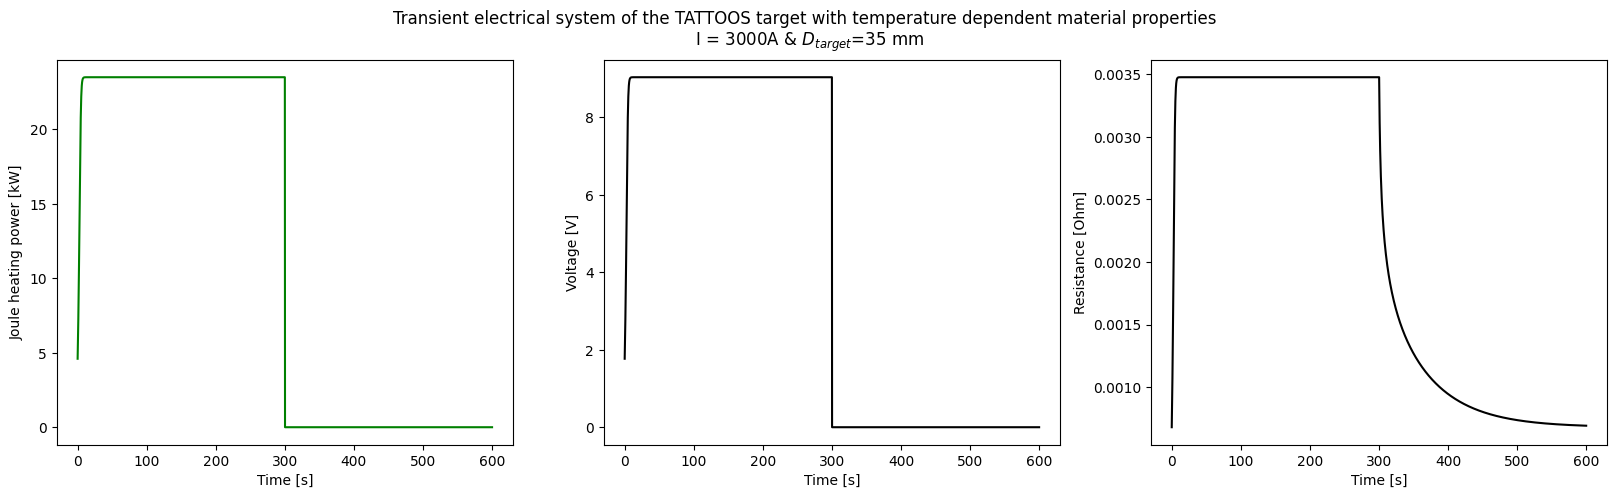

Computation time: 1.20


In [3]:
time_start = time.perf_counter()
def Temperature(T):
    return rho*V*Cp(T)*(T-T_previous)/dt + 2*k*A_cond*(T-T_amb)/L_cond + sigma*S_rad*(np.power(T,4)-np.power(T_amb,4))/(1/Eps(T)+(r_out/r_pot)*((eps_pot-1)/eps_pot)) - Res(T)*L_cont/S_joule*I**2 - P_ebw 

#Parameters
#Geometry container 
r_out=0.0175                                 # External radius of the Ta container[m]
e=0.0005                                    # Thickness of the Ta container[m]
L_cont=0.2                                   # Length of the container[m]
L_ta=0.1                                     # Effective thickness foils
V_cont=np.pi*(r_out**2-(r_out-e)**2)*L_cont  # Volume of the container only [m3]
V_full=V_cont+np.pi*((r_out-e)**2)*L_ta      # Volume if the container is full of Ta [m3]
S_rad=2*np.pi*r_out*L_cont                   # Radiating surface of the Ta container [m2]
S_joule=np.pi*(r_out**2-(r_out-e)**2)

#Conduction
A_cond=0.04*0.005                            # Cross section of the conductors
L_cond=0.06                                  # Length of the conductors

#Radiation
r_pot=0.2
S_pot=2*np.pi*r_pot*L_cont
eps_pot=0.1

#Time
t_cycle=300
n_cycle=2
t_tot=t_cycle*n_cycle
dt=0.25
u=1/dt
samp=int(u*t_tot+1)
t=np.linspace(0,t_tot,samp)

sigma=5.67*1e-8                              # Stefan-Boltzmann constant
m_full=rho*V_full                            # Mass of the target filled with Ta
m_cont=rho*V_cont                            # Mass of the container only

print("Mass of the target [kg]:",round(m_full,2))
print("Mass of the container [kg]:",round(m_cont,2))

#Computation
Temp=[]
dT=[]
T=393.15
T_previous=393.15
T_amb=393.15 #K
P_Joule=[]
U=[]
R=[]

m=m_cont
V=V_cont

for item in t:
    if item<300:
        I=2600
        P_ebw=0
    elif 300<item<600:
        I=0
        P_ebw=0
    P_Joule.append(1e-3*Res(T)*L_cont/S_joule*I**2)
    U.append(Res(T)*L_cont/S_joule*I)
    R.append(Res(T)*L_cont/S_joule)
    T=fsolve(Temperature,1500)
    T=float(T)
    Temp.append(T)
    dT.append((T-T_previous)/dt)
    T_previous=T                     

print("Final cooling temperature in [K] after {}s:".format(t_tot),round(T,2))
print("Final cooling temperature in [°C] after {}s:".format(t_tot),round(T-273.15,2))
print("Maximum temperature in [K]:",round(max(Temp),2))
print("Maximum temperature in [°C]:",round(max(Temp)-273.15,2))
print("Maximum power in [kW]:",round(max(P_Joule),2))

#Plot Thermal
fig, axs = plt.subplots(1,2,figsize=(16,5))  
fig.suptitle("Transient temperature of the TATTOOS target with temperature dependent material properties \n I = 3000A $D_{target}$=35 mm")

axs[0].plot(t,Temp,c='r')
axs[0].set(xlabel='Time [s]', ylabel='Temperature [K]')

axs[1].plot(t,dT,c='b')
axs[1].set(xlabel='Time [s]', ylabel='Cooling rate [K/s]')
#fig.savefig("Analytical cooling TATTOOS - Thermal", dpi=500)
plt.show()

#Plot Electrical
fig, axs = plt.subplots(1,3,figsize=(20,5))  
fig.suptitle("Transient electrical system of the TATTOOS target with temperature dependent material properties \n I = 3000A & $D_{target}$=35 mm")

axs[0].plot(t,P_Joule,c='g')
axs[0].set(xlabel='Time [s]', ylabel='Joule heating power [kW]')

axs[1].plot(t,U,c='black')
axs[1].set(xlabel='Time [s]', ylabel='Voltage [V]')

axs[2].plot(t,R,c='black')
axs[2].set(xlabel='Time [s]', ylabel='Resistance [Ohm]')
#fig.savefig("Analytical cooling TATTOOS - Electrical", dpi=500)
plt.show()

plt.show()

time_elapsed = time.perf_counter() - time_start
print(f"Computation time: {time_elapsed:.2f}")

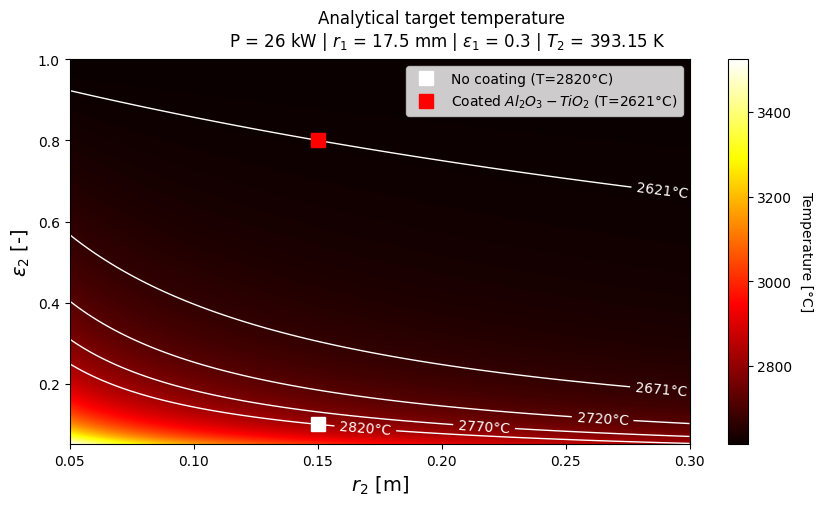

In [4]:
# Constants and parameters
P = 26000  # Power in Watts
T_amb = 393.15  # Ambient temperature in Kelvin
eps = 0.3  # Emissivity of Tantalum
sigma = 5.67e-8  # Stefan-Boltzmann constant (W/m^2/K^4)
r_out = 0.0175  # Outer radius in meters
L_cont=0.2                                   # Length of the container[m]
S_rad=2 * np.pi * r_out * L_cont                   # Radiating surface of the Ta container [m2]

eps_pot = np.linspace(0.05, 1, 500)
r_pot_values = np.linspace(0.05, 0.3, 500)

# Function to calculate radiative temperature
def T_Rad(T_amb, P, eps, r_out, r_pot, eps_pot, sigma, S_rad):
    return np.power(np.power(T_amb, 4) + P * (1 / eps + r_out / r_pot * ((1-eps_pot)/eps_pot)) / (sigma * S_rad), 1 / 4) -273.15

# Calculate temperature for each combination of eps_pot and r_pot
T_grid = np.zeros((len(eps_pot), len(r_pot_values)))
for i, eps_val in enumerate(eps_pot):
    for j, r_pot_val in enumerate(r_pot_values):
        T_grid[i, j] = T_Rad(T_amb, P, eps, r_out, r_pot_val, eps_val, sigma, S_rad)

# Define the specific point to highlight
ref_eps_pot = 0.1  # Pot emissivity
ref_r_pot = 0.15    # Pot radius in meters

# Define the specific point to highlight
opt_eps_pot = 0.8  
opt_r_pot = ref_r_pot 

eps_ref_index = np.argmin(np.abs(eps_pot - ref_eps_pot))
r_pot_ref_index = np.argmin(np.abs(r_pot_values - ref_r_pot))

eps_opt_index = np.argmin(np.abs(eps_pot - opt_eps_pot))
r_pot_opt_index = np.argmin(np.abs(r_pot_values - opt_r_pot))

ref_temp = T_grid[eps_ref_index, r_pot_ref_index]
opt_temp = T_grid[eps_opt_index, r_pot_opt_index]


fig = plt.figure(figsize=(10, 5))

heatmap = plt.imshow(T_grid, extent=[r_pot_values.min(), r_pot_values.max(), eps_pot.min(), eps_pot.max()], 
                    origin='lower', aspect='auto', cmap='hot')

cbar = plt.colorbar(heatmap)
cbar.set_label('Temperature [°C]', rotation=270, labelpad=15)

# Add contour lines
contour_levels = np.linspace(opt_temp, ref_temp, 5)  # 5 contour levels
contours = plt.contour(
    r_pot_values, eps_pot, T_grid, levels=contour_levels, colors='white', linewidths=1
)
plt.clabel(contours, inline=True, fontsize=10, fmt="%.0f°C")  # Add labels to contours

plt.plot(ref_r_pot, ref_eps_pot, 'ws', markersize=10, label=f'No coating (T={ref_temp:.0f}°C)')
plt.plot(opt_r_pot, opt_eps_pot, 'rs', markersize=10, label=f'Coated $Al_2O_3 - TiO_2$ (T={opt_temp:.0f}°C)')

plt.xlabel('$r_{2}$ [m]', fontsize=14)
plt.ylabel('$\epsilon_{2}$ [-]', fontsize=14)
fig.suptitle(f'Analytical target temperature \n P = 26 kW | $r_1$ = {r_out*1e3} mm | $\epsilon_1$ = {eps} | $T_2$ = {T_amb} K')
plt.legend()
#plt.savefig("Influence of the surrounding walls on the temperature of the TATTOOS target", dpi=500)
plt.show()

In [18]:
#Geometry container 
e=0.0005                                     # Thickness of the Ta container[m]
L_cont=0.2                                   # Length of the container[m]
L_ta=0.1                                     # Effective thickness foils
V_cont=np.pi*(r_out**2-(r_out-e)**2)*L_cont  # Volume of the container only [m3]
V_full=V_cont+np.pi*((r_out-e)**2)*L_ta      # Volume if the container is full of Ta [m3]
S_rad=2*np.pi*r_out*L_cont                   # Radiating surface of the Ta container [m2]
S_joule=np.pi*(r_out**2-(r_out-e)**2)
I = 2600

# Constants for new heatmap
r_out_values = np.linspace(0.015, 0.03, 500)  # Outer radius in meters
eps_target_values = np.linspace(0.1, 1, 500)  # Target emissivity values

# Compute the temperature grid for the new heatmap
T_grid = np.zeros((len(eps_target_values), len(r_out_values)))
P_grid = np.zeros((len(eps_target_values), len(r_out_values)))

for i, eps_target in enumerate(eps_target_values):
    for j, r_out_val in enumerate(r_out_values):
        S_joule=np.pi*(r_out_val**2-(r_out_val-e)**2)
        def Temperature(T):
            return sigma*S_rad*(np.power(T,4)-np.power(T_amb,4))/(1/eps_target+(0.15/r_out_val)*((1/eps_pot)-1)) - Res(T)*L_cont/S_joule*I**2
        T_grid[i, j] = fsolve(Temperature,1500)
        #P_grid[i, j] = Res(T)*L_cont/S_joule*I**2
        
# Plot the second heatmap
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))
heatmap = ax1.imshow(P_grid, 
                    extent=[r_out_values.min(), r_out_values.max(), eps_target_values.min(), eps_target_values.max()], 
                    origin='lower', aspect='auto', cmap='Blues')

cbar = plt.colorbar(heatmap)
cbar.set_label('Power [W]', rotation=270, labelpad=15)

# Labeling the axes
ax1.set_xlabel('$r_{out}$ [m]', fontsize=14)
ax1.set_ylabel('$\epsilon_{target}$', fontsize=14)
#ax1.title('Analytical Target Temperature Heatmap \n $r_{pot} = 0.2$ m | $\epsilon_{pot} = 0.8$')

heatmap = ax2.imshow(T_grid, 
                    extent=[r_out_values.min(), r_out_values.max(), eps_target_values.min(), eps_target_values.max()], 
                    origin='lower', aspect='auto', cmap='Reds')

cbar = plt.colorbar(heatmap)
cbar.set_label('Temperature [°C]', rotation=270, labelpad=15)

# Labeling the axes
ax2.set_xlabel('$r_{out}$ [m]', fontsize=14)
ax2.set_ylabel('$\epsilon_{target}$', fontsize=14)

plt.show()

ValueError: The array returned by a function changed size between calls

C:\Users\martin_r\AppData\Local\Temp\ipykernel_23704\1846358760.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(fsolve(temperature_equation, T_initial_guess,
C:\Users\martin_r\AppData\Local\Temp\ipykernel_23704\1846358760.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(fsolve(temperature_radiation_only, T_initial_guess,


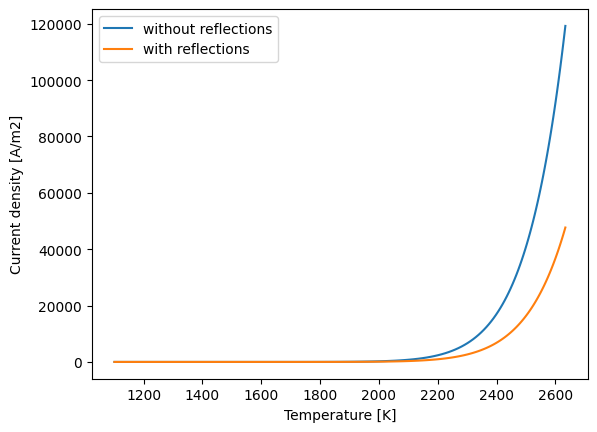

Final temperature (full model): 2633.78 K
Final temperature (radiation only): 2749.14 K


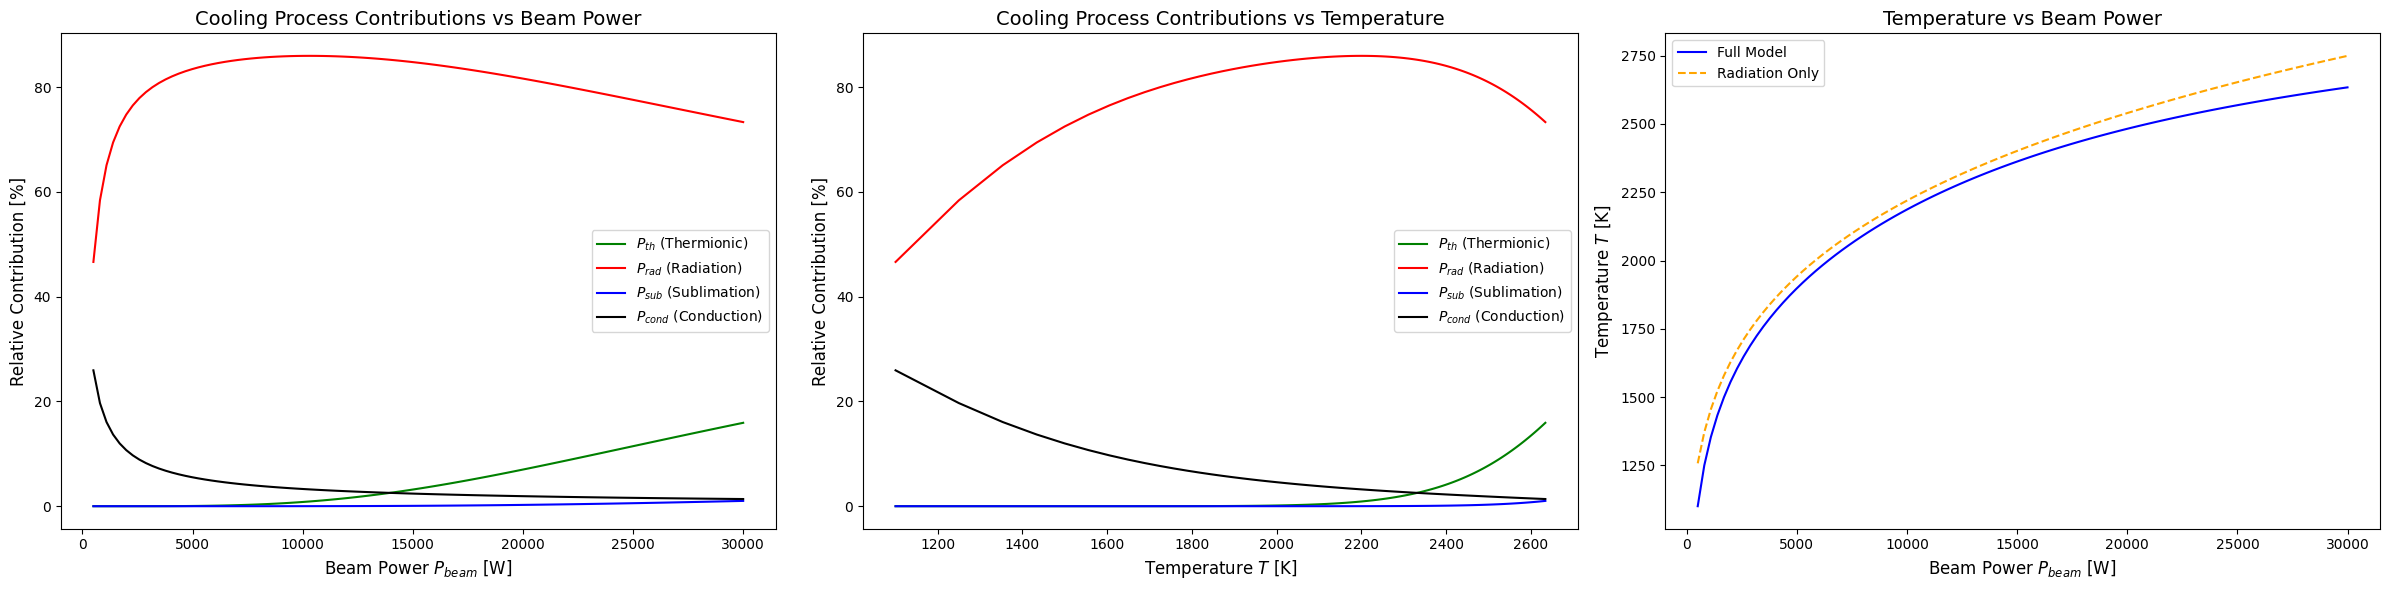

In [ ]:
# Function for temperature calculation
def temperature_equation(T, P, T_amb, H, sigma, k, A_cond, L_cond, S_container, r_target, S_sub, R, Ar, Phi_e, kb, q):
    """
    Calculates the temperature of the target 
    while accounting for all the cooling processes
    """
    term_conduction = 2 * k * A_cond * (T - T_amb) / L_cond
    term_radiation = sigma * S_container * (np.power(T, 4) - np.power(T_amb, 4)) / (
        1 / Eps(T) + (r_target / 0.15) * ((1-0.1) / 1)
    )
    term_sublimation = H * S_sub * np.power(10, 7.86 - (39310 / (T + 200)))
    term_emission = (1 - R) * Ar * T**2 * np.exp(-Phi_e / (kb / q * T)) * S_container * (Phi_e + 2 * kb * T / q)
    return term_conduction + term_radiation + term_sublimation + term_emission - P

# Function for temperature calculation with only thermal radiation
def temperature_radiation_only(T, P, T_amb, sigma, S_container,r_target):
    """
    Calculates the temperature of the target 
    accounting only for thermal radiation
    """
    term_radiation = sigma * S_container * (np.power(T, 4) - np.power(T_amb, 4)) / (
        1 / Eps(T) + (r_target / 0.15) * ((1-0.1) / 1)
    )
    return term_radiation - P

# Container parameters
r_target = 0.0175  # [m]
e = 0.0005         # [m]
L = 0.2            # [m]
S_container = 2 * np.pi * r_target * L
n_foils = 4000
S_sub = 2 * S_container + n_foils * 2 * np.pi * (r_target - e)**2 * 1e4  # Sublimation surface area

# Thermionic emission parameters
Ar = 1.20173e6  # Richardson constant [A/m^2 K^2]
Phi_e = 4.1     # Work function [eV]
kb = 1.380649e-23  # Boltzmann constant [J/K]
q = 1.602e-19      # Elementary charge [C]
R = 0.6         # Reflection coefficient (amount of emitted electrons that go back to the target)

# Conduction parameters
k = 55              # Thermal conductivity [W/mK]
A_cond = 0.04 * 0.005  # Conduction area [m^2]
L_cond = 0.06       # Conduction length [m]

# Beam power range
P_beam = np.linspace(500, 30000, 100)  # [W]

# Constants
T_amb = 393.15  # Ambient temperature [K]
H = 4300        # Sublimation constant
sigma = 5.67e-8  # Stefan-Boltzmann constant [W/m^2 K^4]

# Solve for temperatures for all beam powers (full model)
T_initial_guess = 2000  # Initial guess for T
temperatures = np.array([
    float(fsolve(temperature_equation, T_initial_guess, 
                 args=(power, T_amb, H, sigma, k, A_cond, L_cond, S_container, r_target, S_sub, R, Ar, Phi_e, kb, q)))
    for power in P_beam
])

# Solve for temperatures with only thermal radiation
temperatures_radiation_only = np.array([
    float(fsolve(temperature_radiation_only, T_initial_guess,
                 args=(power, T_amb, sigma, S_container, r_target)))
    for power in P_beam
])

# Calculate contributions using vectorized operations
P_sublimation = H * np.power(10, 7.86 - 39310 / (temperatures + 200)) * S_sub
P_radiation = sigma * S_container * (np.power(temperatures, 4) - np.power(T_amb, 4)) / (
    1 / Eps(temperatures) + (S_container / 0.15) * ((1 / 0.3) - 1)
)
P_emission = (1 - R) * Ar * temperatures**2 * np.exp(-Phi_e / (kb / q * temperatures)) * S_container * (Phi_e + 2 * kb * temperatures / q)
P_conduction = k * A_cond * (temperatures - T_amb) / L_cond

# Plot the current density as function of temperature with and without reflections (in between check)
# Careful of space charge effetcs: to check.
J_th = Ar * temperatures**2 * np.exp(-Phi_e / (kb / q * temperatures)) #Current density of emitted electrons
plt.plot(temperatures, J_th,label="without reflections")
plt.plot(temperatures, J_th*(1-R),label="with reflections")
plt.xlabel("Temperature [K]")
plt.ylabel("Current density [A/m2]")
plt.legend()
plt.show()

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Subplot 1: Cooling processes vs beam power
axes[0].plot(P_beam, P_emission / P_beam * 100, c='g', label="$P_{th}$ (Thermionic)")
axes[0].plot(P_beam, P_radiation / P_beam * 100, c='r', label="$P_{rad}$ (Radiation)")
axes[0].plot(P_beam, P_sublimation / P_beam * 100, c='b', label="$P_{sub}$ (Sublimation)")
axes[0].plot(P_beam, P_conduction / P_beam * 100, c='black', label="$P_{cond}$ (Conduction)")
axes[0].set_xlabel('Beam Power $P_{beam}$ [W]', fontsize=12)
axes[0].set_ylabel('Relative Contribution [%]', fontsize=12)
axes[0].set_title('Cooling Process Contributions vs Beam Power', fontsize=14)
axes[0].legend()

# Subplot 2: Cooling processes vs temperature
axes[1].plot(temperatures, P_emission / P_beam * 100, c='g', label="$P_{th}$ (Thermionic)")
axes[1].plot(temperatures, P_radiation / P_beam * 100, c='r', label="$P_{rad}$ (Radiation)")
axes[1].plot(temperatures, P_sublimation / P_beam * 100, c='b', label="$P_{sub}$ (Sublimation)")
axes[1].plot(temperatures, P_conduction / P_beam * 100, c='black', label="$P_{cond}$ (Conduction)")
axes[1].set_xlabel('Temperature $T$ [K]', fontsize=12)
axes[1].set_ylabel('Relative Contribution [%]', fontsize=12)
axes[1].set_title('Cooling Process Contributions vs Temperature', fontsize=14)
axes[1].legend()

# Subplot 3: Temperature vs beam power (comparison)
axes[2].plot(P_beam, temperatures, c='blue', label="Full Model")
axes[2].plot(P_beam, temperatures_radiation_only, c='orange', linestyle='--', label="Radiation Only")
axes[2].set_xlabel('Beam Power $P_{beam}$ [W]', fontsize=12)
axes[2].set_ylabel('Temperature $T$ [K]', fontsize=12)
axes[2].set_title('Temperature vs Beam Power', fontsize=14)
axes[2].legend()

# Show the final temperature
final_temperature = temperatures[-1]
print(f"Final temperature (full model): {final_temperature:.2f} K")
final_temperature_radiation = temperatures_radiation_only[-1]
print(f"Final temperature (radiation only): {final_temperature_radiation:.2f} K")

# Display the plots
plt.tight_layout()
plt.show()

In [189]:
def Beth_Bloch(KINETIC_ENERGY,CURRENT):
    """
    Computes the stopping power in MeV/(g/cm2) for Tantalum given the beam energy and beam intensity
    """
    # Bethe-Bloch
    PROTON_MASS = 0.938272088  # GeV
    POWER = CURRENT / co.e * KINETIC_ENERGY * co.eV * 1e9  # W
    TOTAL_ENERGY = PROTON_MASS + KINETIC_ENERGY  # GeV
    MOMENTUM = np.sqrt(TOTAL_ENERGY**2 - PROTON_MASS**2)  # GeV
    GAMMA = TOTAL_ENERGY / PROTON_MASS
    BETA = np.sqrt(1.0 - (1.0 / GAMMA ** 2))
    W_A = 180.94788  # relative atomic mass of tantalum 
    W_Z = 73  # tantalum atomic number
    RHO_W = 16.65  # density of graphite kg/cm^3

    I_MEP = 10 * W_Z * co.eV  # J

    return 0.3071  * W_Z / W_A * (1/(BETA ** 2)) * \
           (np.log(2 * co.m_e * co.c ** 2 * BETA ** 2 / (I_MEP * 
           (1 - BETA ** 2))) - BETA ** 2)  


# Beam parameters TRIUMF
KINETIC_ENERGY = 0.48# GeV
CURRENT = 40  # microA
dEdx = Beth_Bloch(KINETIC_ENERGY,CURRENT)

print("**** 480 MeV and 0.1 mA ****")
print(f"From Bethe-Bloch dEdx= {round(dEdx,3)} MeV/(g/cm2)")
print("SRIM Laxdal et al.  dEdx= 1.522 MeV/(g/cm2)\n") #from Laxdal et al. Rotating proton beam for higher RIB releases

# Beam parameters TATTOOS
KINETIC_ENERGY = 0.59# GeV
CURRENT = 100 # microA
dEdx = Beth_Bloch(KINETIC_ENERGY,CURRENT)

L_TARGET = 0.025 # cm 

print("**** 590 MeV and 0.1 mA ****")
print(f"From Bethe-Bloch dEdx= {round(dEdx,3)} MeV/(g/cm2) \n")


dEdx = dEdx * 16.650 #from MeV/(g/cm2) to MeV/cm

P = CURRENT * dEdx * L_TARGET 
print(f"Power = {round(P,2)} W")


**** 480 MeV and 0.1 mA ****
From Bethe-Bloch dEdx= 1.527 MeV/(g/cm2)
SRIM Laxdal et al.  dEdx= 1.522 MeV/(g/cm2)

**** 590 MeV and 0.1 mA ****
From Bethe-Bloch dEdx= 1.417 MeV/(g/cm2) 

Power = 58.96 W
